# Creating a Machine Learning Model to predict the quality of wine


Clone the repository and change the directory

In [1]:
!git clone https://github.com/LeoGaunt/csc2034_DataScience_WineQuality.git

Cloning into 'csc2034_DataScience_WineQuality'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 25 (delta 6), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 737.42 KiB | 7.52 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
import os
os.chdir("csc2034_DataScience_WineQuality/data")

## Exploring the 2 Datasets

Now we have imported the datasets into collab, we can now explore the datasets and visualise them to help our understanding.

I will first look at how many wines are of each quality

I start this process by loading all the data in from the csv using the `pandas` module

In [3]:
import pandas as pd

# Load the Data
red_wine = pd.read_csv("winequality-red.csv", delimiter=";")
white_wine = pd.read_csv("winequality-white.csv", delimiter=";")

Now that the data has been importet I can now validate the data to check that it is ready to use. I will check for:



*   Missing Values
*   Values are Numeric



In [4]:
# Check for Missing Values (Outputs True if correct)
print("Red Wine Complete Dataset: ", not red_wine.isnull().values.any())
print("White Wine Complete Dataset: ", not white_wine.isnull().values.any())

# Check All value are numeric (Outputs True if correct)
print("Red Wine All Numeric: ", red_wine.select_dtypes(exclude=['number']).empty)
print("White Wine All Numeric: ", white_wine.select_dtypes(exclude=['number']).empty)

Red Wine Complete Dataset:  True
White Wine Complete Dataset:  True
Red Wine All Numeric:  True
White Wine All Numeric:  True


I also want to be able to interpret the data as a whole and not separated for red and white

In [5]:
wine_all = pd.concat([red_wine, white_wine], ignore_index=True)

Now that we have loaded the data we can have a look at how many wines in both red and white are of which quality

In [6]:
# Check unique quality values
print(red_wine["quality"].value_counts().sort_index())
print(white_wine["quality"].value_counts().sort_index())
print(wine_all["quality"].value_counts().sort_index())

quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64
quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: count, dtype: int64
quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64


We can now see the values of the qualities of each wine, however it would be much better if we could see this on a graph to visualise the data. I am going to use `matplotlib` to create a histogram and box plot for this data

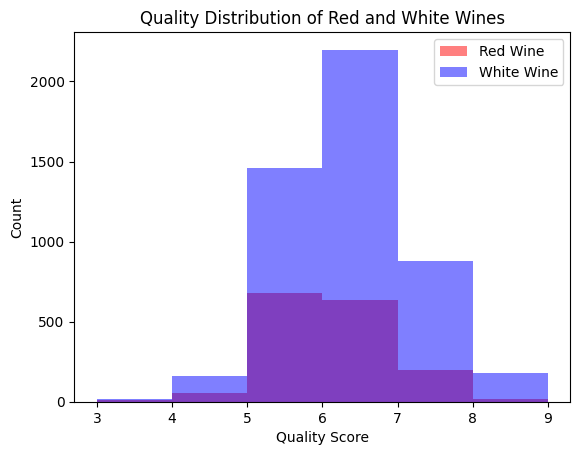

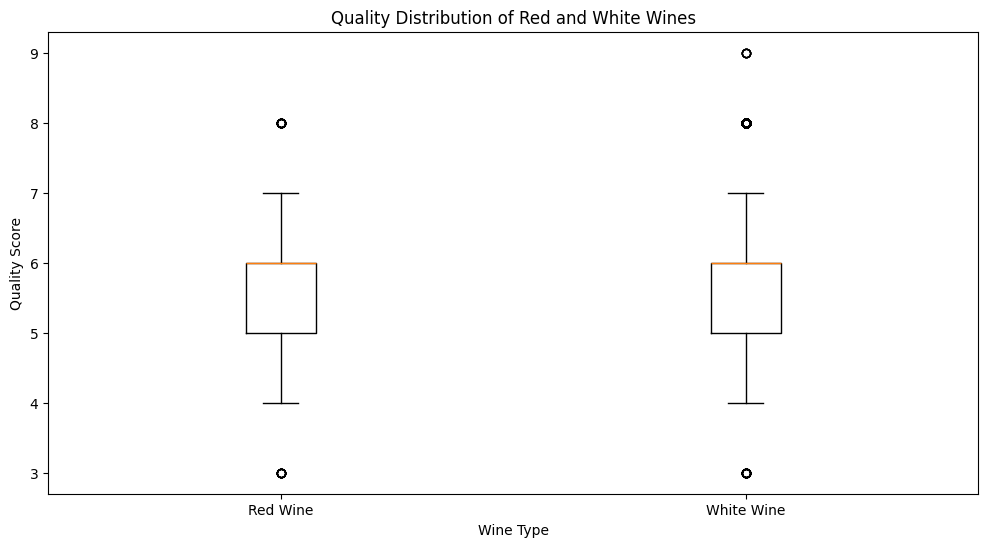

In [7]:
import matplotlib.pyplot as plt

# Plot the distributions

plt.hist(red_wine["quality"], alpha=0.5, label="Red Wine", color="red", bins=range(3, 10))
plt.hist(white_wine["quality"], alpha=0.5, label="White Wine", color="blue", bins=range(3, 10))
plt.legend(loc="upper right")
plt.xlabel("Quality Score")
plt.ylabel("Count")
plt.title("Quality Distribution of Red and White Wines")
plt.show()

plt.figure(figsize=(12,6))
plt.boxplot([red_wine["quality"], white_wine["quality"]], tick_labels=["Red Wine", "White Wine"])
plt.xlabel("Wine Type")
plt.ylabel("Quality Score")
plt.title("Quality Distribution of Red and White Wines")
plt.show()

Although these graphs were technically correct, I found that the historgram was harder to interpret due to the fact that there are over 200% more datapoints for white wine than red wine. Therefore I found I must normalise the data before interpreting from it to make it easier to interpret.

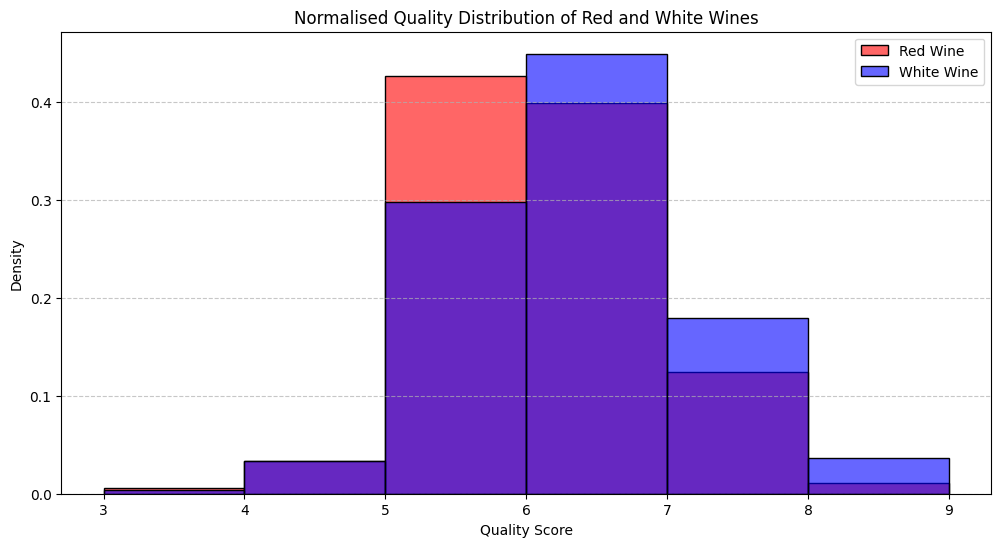

In [39]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.histplot(red_wine["quality"], bins=range(3, 10), kde=False, color="red", label="Red Wine", alpha=0.6, stat="density")
sns.histplot(white_wine["quality"], bins=range(3, 10), kde=False, color="blue", label="White Wine", alpha=0.6, stat="density")
plt.xlabel("Quality Score")
plt.ylabel("Density")
plt.title("Normalised Quality Distribution of Red and White Wines")
plt.legend()
plt.xticks(range(3, 10))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Overall we can see that most wines fall between the quality of 5 and 7. Now that the graph is normalised, it is much easier to see that white wines have a higher density of higher quality ratings compared to the red wine.

After looking at the wines separately for reds and whites, I want to now look at both datasets together to make some generalised comments

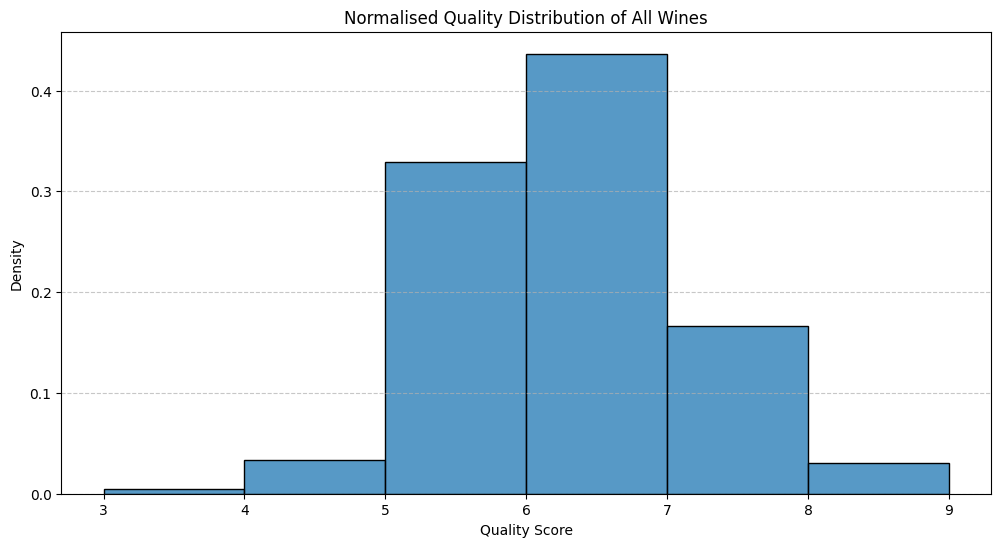

In [40]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.histplot(wine_all["quality"], bins=range(3, 10), kde=False, stat="density")
plt.xlabel("Quality Score")
plt.ylabel("Density")
plt.title("Normalised Quality Distribution of All Wines")
plt.xticks(range(3, 10))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### Comparing quality against alcohol content

We can do this by discretising the alcohol content variables into low, med and high based on its distribution. This will be decided by

* `low < (avg - stddev)`
* `(avg - stddev) < med < (avg + stddev)`
* `(avg + stddev) < high`

I do this by creating a 3-valued `alcohol_cat` variable. I will use `pd.cut()` to split the `DataFrames`, by using pre-calculated bins that act as the defining area to split.

In [10]:
red_bins = [0,
        (red_wine["alcohol"].mean() - red_wine["alcohol"].std()),
        (red_wine["alcohol"].mean() + red_wine["alcohol"].std()),
        float('inf')]

white_bins = [0,
        (white_wine["alcohol"].mean() - white_wine["alcohol"].std()),
        (white_wine["alcohol"].mean() + white_wine["alcohol"].std()),
        float('inf')]

labels = ["low", "med", "high"]

red_wine["alcohol_cat"] = pd.cut(red_wine["alcohol"], bins=red_bins, labels=labels)
white_wine["alcohol_cat"] = pd.cut(white_wine["alcohol"], bins=white_bins, labels=labels)

Now that the wines have been sorted into discrete bins, we can look at the raw values.

In [11]:
print(red_wine["alcohol_cat"].value_counts().sort_index())
print(white_wine["alcohol_cat"].value_counts().sort_index())

alcohol_cat
low      194
med     1125
high     280
Name: count, dtype: int64
alcohol_cat
low      845
med     3121
high     932
Name: count, dtype: int64


We can now describe the wine quality as we did earlier, but serperately for low, mid and high alcohol content. However this is now going to be done with a combination of all wines, not separate for red and white.

Now I will create a boxplot to show the variation

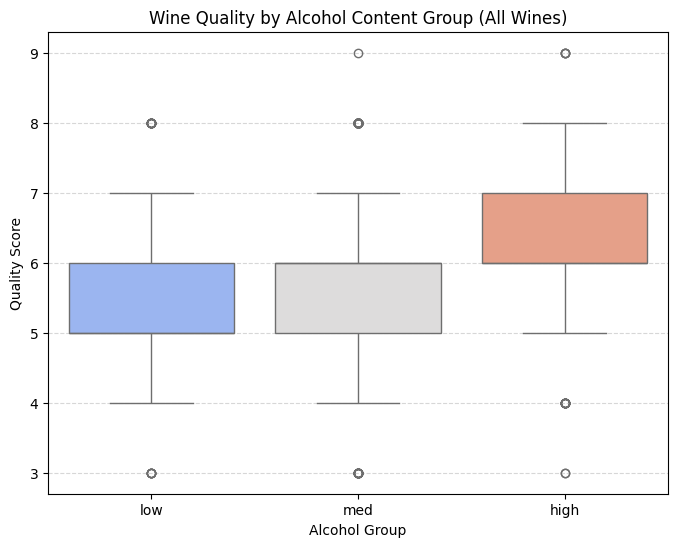

In [13]:
plt.figure(figsize=(8,6))
sns.boxplot(x="alcohol_cat", y="quality", data=wine_all, hue="alcohol_cat", palette="coolwarm")
plt.title("Wine Quality by Alcohol Content Group (All Wines)")
plt.xlabel("Alcohol Group")
plt.ylabel("Quality Score")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

DESCRIPTION NEEDED

### Plotting the residual sugar variable and identify "sweet" and "dry" wines

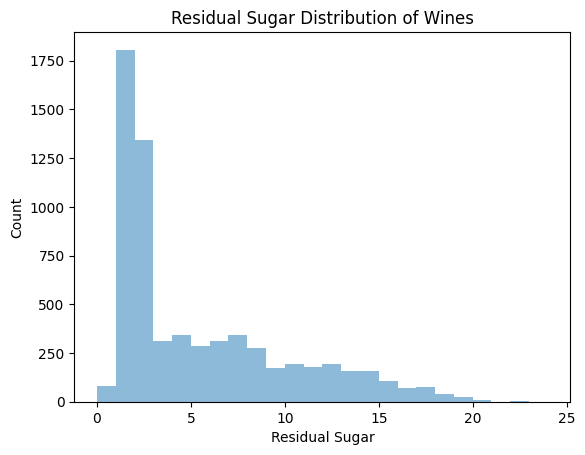

In [14]:
plt.hist(wine_all["residual sugar"], alpha=0.5, bins=range(0, 25))
plt.xlabel("Residual Sugar")
plt.ylabel("Count")
plt.title("Residual Sugar Distribution of Wines")
plt.show()

Defining this now into sweet and dry. (I first tried using a qcut approach but this is now done differently - maybe add to report)

In [15]:
threshold = wine_all["residual sugar"].median()
print("Threshold for 'isSweet':", threshold)
wine_all["isSweet"] = wine_all["residual sugar"] > threshold

Threshold for 'isSweet': 3.0


### Distribution Analysis of Quality vs isSweet

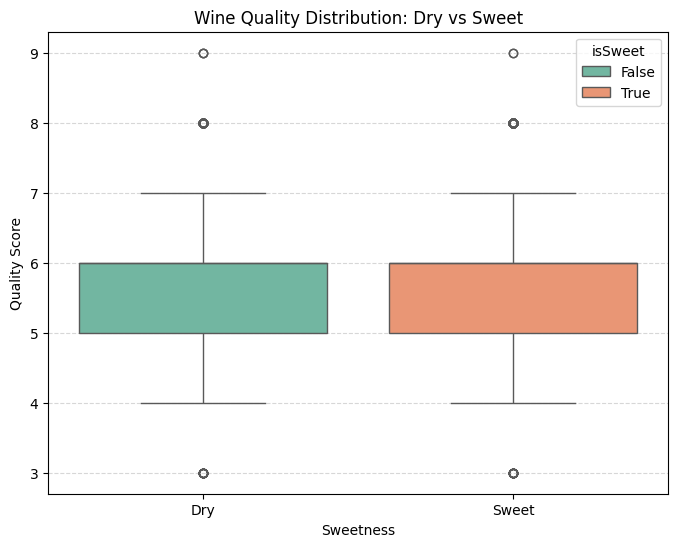

In [16]:
plt.figure(figsize=(8,6))
sns.boxplot(x="isSweet", y="quality", data=wine_all, hue="isSweet", palette=["#66c2a5", "#fc8d62"])
plt.xticks([0, 1], ["Dry", "Sweet"])
plt.xlabel("Sweetness")
plt.ylabel("Quality Score")
plt.title("Wine Quality Distribution: Dry vs Sweet")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

DESCRIPTION NEEDED

## Determining which subset of variables is most useful for learning

For this part, I need to calculate the correlations between each pair the variables. I will do this by creating a Correlation Matrix. I will do this by using the `seaborn` package and displaying as a heatmap

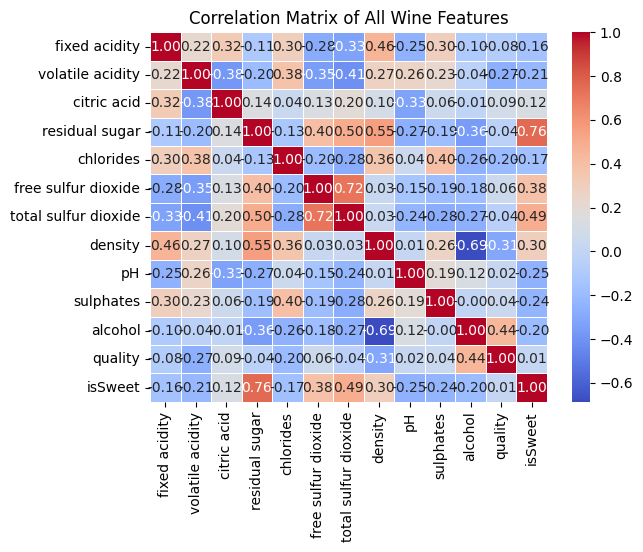

In [17]:
corr_matrix = wine_all.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of All Wine Features")
plt.show()

I have chosen to use the pearson ranking method as it makes sense that linear relationships seem reasonable for wine quality (do I need to explain why?)

COMMENT ON RELATIONSHIPS BETWEEN THEM

For my models I am going to use my 5 most correlated features with quality. These were

| Feature | Correllation |
| --- | ---|
| alcohol | +0.44 |
| sulphates | +0.25 |
| volitile acidity | -0.27 |
| density | -0.26 |
| chlorides | -0.20 |

## Experiment with machine learning approaches

### Binary Classification

I am going to start by creating a binary classifier. As I believe this will be the easiest to implement as it simplifies the problem and can then move into Multi-Class classification.

I am going to start by creating a new column on the DataFrame that allows me to determine 1 for high quality and 0 for low quality. My initial threshold will be 6.

In [18]:
wine_all["quality_label"] = (wine_all["quality"] >= 6).astype(int)

I will now define X and y with my features

In [19]:
features = ["alcohol", "sulphates", "volatile acidity", "density", "chlorides"]

X = wine_all[features]
y_binary = wine_all["quality_label"]

I am now going to split and scale my data

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 80% train, 20% test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

scaler = StandardScaler()

# Fit on training data only
X_train_scaled = scaler.fit_transform(X_train_clf)

# Apply same transformation to test data
X_test_scaled = scaler.transform(X_test_clf)

### Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

# initialise
log_reg = LogisticRegression(max_iter=1000, random_state=42)
# train
log_reg.fit(X_train_scaled, y_train_clf)
# predict
y_pred = log_reg.predict(X_test_scaled)

Evaluate the model

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test_clf, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_clf, y_pred))
print("\nClassification Report:\n", classification_report(y_test_clf, y_pred))

Accuracy: 0.7246153846153847

Confusion Matrix:
 [[258 219]
 [139 684]]

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.54      0.59       477
           1       0.76      0.83      0.79       823

    accuracy                           0.72      1300
   macro avg       0.70      0.69      0.69      1300
weighted avg       0.72      0.72      0.72      1300



### Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

# initlialise
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# train
rf.fit(X_train_scaled, y_train_clf)
# predict
y_pred_rf = rf.predict(X_test_scaled)

Evaluate the model

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test_clf, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_clf, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test_clf, y_pred_rf))

Accuracy: 0.8153846153846154

Confusion Matrix:
 [[339 138]
 [102 721]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.71      0.74       477
           1       0.84      0.88      0.86       823

    accuracy                           0.82      1300
   macro avg       0.80      0.79      0.80      1300
weighted avg       0.81      0.82      0.81      1300



### Continuous Regression

Define X and y with my features

In [25]:
features = ["alcohol", "sulphates", "volatile acidity", "density", "chlorides"]

X = wine_all[features]
y_reg = wine_all["quality"]

Split and scale the data

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reg)
X_test_scaled = scaler.transform(X_test_reg)

### Linear Regression

In [27]:
from sklearn.linear_model import LinearRegression

# initialise
lin_reg = LinearRegression()
# train
lin_reg.fit(X_train_scaled, y_train_reg)
# predict
y_pred = lin_reg.predict(X_test_scaled)

Evaluate the model

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test_reg, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
r2 = r2_score(y_test_reg, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 0.57
RMSE: 0.74
R² Score: 0.26


### Random Forest Regressor

In [29]:
from sklearn.ensemble import RandomForestRegressor

# initialise
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
# train
rf_reg.fit(X_train_scaled, y_train_reg)
# predict
y_pred_rf = rf_reg.predict(X_test_scaled)

Evaluate the model

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_rf = mean_absolute_error(y_test_reg, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_rf))
r2_rf = r2_score(y_test_reg, y_pred_rf)

print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest R² Score: {r2_rf:.2f}")

Random Forest MAE: 0.45
Random Forest RMSE: 0.64
Random Forest R² Score: 0.44


## Model Evaluation using k-fold cross validation

Import needed module

In [31]:
from sklearn.model_selection import cross_val_score

### Binary Classification

### Logistic Regression

In [32]:
f1_scores_log = cross_val_score(log_reg, X_train_scaled, y_train_clf, cv=5, scoring='f1')
accuracy_scores_log = cross_val_score(log_reg, X_train_scaled, y_train_clf, cv=5, scoring='accuracy')
auc_scores = cross_val_score(log_reg, X_train_scaled, y_train_clf, cv=5, scoring='roc_auc')

print("Logistic Regression Cross-Validation Results:")
print(f"Mean F1 Score: {f1_scores_log.mean():.3f}")
print(f"Std Dev F1 Score: {f1_scores_log.std():.3f}")
print(f"Mean Accuracy: {accuracy_scores_log.mean():.3f}")
print(f"Mean AUC Score: {auc_scores.mean():.3f}")

Logistic Regression Cross-Validation Results:
Mean F1 Score: 0.775
Std Dev F1 Score: 0.001
Mean Accuracy: 0.632
Mean AUC Score: 0.505


### Random Forest Classifier

In [33]:
f1_scores = cross_val_score(rf, X_train_scaled, y_train_clf, cv=5, scoring='f1')
accuracy_scores = cross_val_score(rf, X_train_scaled, y_train_clf, cv=5, scoring='accuracy')
auc_scores = cross_val_score(rf, X_train_scaled, y_train_clf, cv=5, scoring='roc_auc')

print("Random Forest Classifier Cross-Validation Results:")
print(f"Mean F1 Score: {f1_scores.mean():.3f}")
print(f"Std Dev F1 Score: {f1_scores_log.std():.3f}")
print(f"Mean Accuracy: {accuracy_scores.mean():.3f}")
print(f"Mean AUC Score: {auc_scores.mean():.3f}")

Random Forest Classifier Cross-Validation Results:
Mean F1 Score: 0.702
Std Dev F1 Score: 0.001
Mean Accuracy: 0.581
Mean AUC Score: 0.507


### Continuous Regression

rmse scorer required

In [34]:
from sklearn.metrics import make_scorer, mean_squared_error

# Custom scorer for RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
# MSE scorer
mse_scorer = 'neg_mean_squared_error'

### Linear Regression

In [37]:
rmse_scores_lin = cross_val_score(lin_reg, X_train_scaled, y_train_reg, cv=5, scoring=rmse_scorer)
mse_scores_lin = cross_val_score(lin_reg, X_train_scaled, y_train_reg, cv=5, scoring=mse_scorer)

print("Linear Regression Cross-Validation Results:")
print(f"Mean RMSE: {-rmse_scores_lin.mean():.3f}")
print(f"Mean MSE: {-mse_scores_lin.mean():.3f}")
print(f"Std Dev RMSE: {rmse_scores_lin.std():.3f}")

Linear Regression Cross-Validation Results:
Mean RMSE: 0.745
Mean MSE: 0.555
Std Dev MSE: 0.013


### Random Forest Regressor

In [38]:
rmse_scores = cross_val_score(rf_reg, X_train_scaled, y_train_reg, cv=5, scoring=rmse_scorer)
mse_scores_lin = cross_val_score(rf_reg, X_train_scaled, y_train_reg, cv=5, scoring=mse_scorer)

print("Random Forest Regressor Cross-Validation Results:")
print(f"Mean RMSE: {-rmse_scores.mean():.3f}")
print(f"Mean MSE: {-mse_scores_lin.mean():.3f}")
print(f"Std Dev RMSE: {rmse_scores_lin.std():.3f}")

Random Forest Regressor Cross-Validation Results:
Mean RMSE: 0.667
Mean MSE: 0.445
Std Dev RMSE: 0.013
